In [1]:
import sys
sys.path.append("..")
import speech_recognition.helper as helper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

We'll start by reading in the data we extracted earlier. For these simple classifiers we won't be worrying about the words not in the command words set.

In [2]:
X_train, y_train = helper.get_fold_data('train', helper.COMMAND_WORDS)
X_val, y_val = helper.get_fold_data('validation', helper.COMMAND_WORDS)
X_test, y_test = helper.get_fold_data('test', helper.COMMAND_WORDS)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 34069
Number of validation samples: 4153
Number of testing samples: 4524
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,3134,377,406
go,3106,372,402
left,3037,352,412
no,3130,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
silence,3300,450,450
stop,3111,350,411
up,2948,350,425


Now that we've loaded in the data, we'll need to reformat it a little so that we can feed them into our neural networks. For the y values, we'll need to transform the labelled words into one hot encoded integers. We'll also need to reshape the X values for the convolutional neural network later, so that it can be treated as an image. For now, we'll just reformat the y values.

In [4]:
y_train_hot = helper.reformat_y(y_train)
y_val_hot = helper.reformat_y(y_val)
y_test_hot = helper.reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (34069, 20, 32)
y_train_hot shape: (34069, 11)


# Single Layer Perceptron

Let's see how a single layer perceptron performs on the data. We'll need to flatten the X values and normalize them first so that the optimizer won't get stuck. For this model, we'll be using the default Adam optimizer. We'll also add an early stopping monitor so that the model stops running once the validation loss hasn't decreased in 3 epochs. This will shorten training time and help avoid overfitting.

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train[0].shape)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train_hot, batch_size=128, epochs=30,
          validation_data=(X_val, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 34069 samples, validate on 4153 samples
Epoch 1/30
34069/34069 [==============================] - 8s 233us/step - loss: 1.5661 - acc: 0.4895 - val_loss: 1.2826 - val_acc: 0.5935
Epoch 2/30
34069/34069 [==============================] - 1s 20us/step - loss: 1.2649 - acc: 0.5918 - val_loss: 1.2504 - val_acc: 0.6063
Epoch 3/30
34069/34069 [==============================] - 1s 20us/step - loss: 1.2259 - acc: 0.6035 - val_loss: 1.2448 - val_acc: 0.6082
Epoch 4/30
34069/34069 [==============================] - 1s 19us/step - loss: 1.2110 - acc: 0.6072 - val_loss: 1.2397 - val_acc: 0.6075
Epoch 5/30
34069/34069 [==============================] - 1s 19us/step - loss: 1.1966 - acc: 0.6118 - val_loss: 1.2379 - val_acc: 0.6092
Epoch 6/30
34069/34069 [==============================] - 1s 19us/step - loss: 1.1907 - acc: 0.6143 - val_loss: 1.2521 - val_acc: 0.6037
Epoch 7/30
34069/34069 [==============================] - 1s 20us/step - loss: 1.1821 - acc: 0.6198 - val_loss: 1.2416 - val_acc

In [6]:
score = model.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

4524/4524 [==============================] - 0s 27us/step
loss 1.2528915454015277
acc 0.5957117595575638


As expected, the single layer perceptron doesn't perform too well. Still, with 10 possible voice commands and only 10 epochs an accuracy of ~56% isn't that bad! Let's plot a confusion matrix to see what it had difficulty classifying.

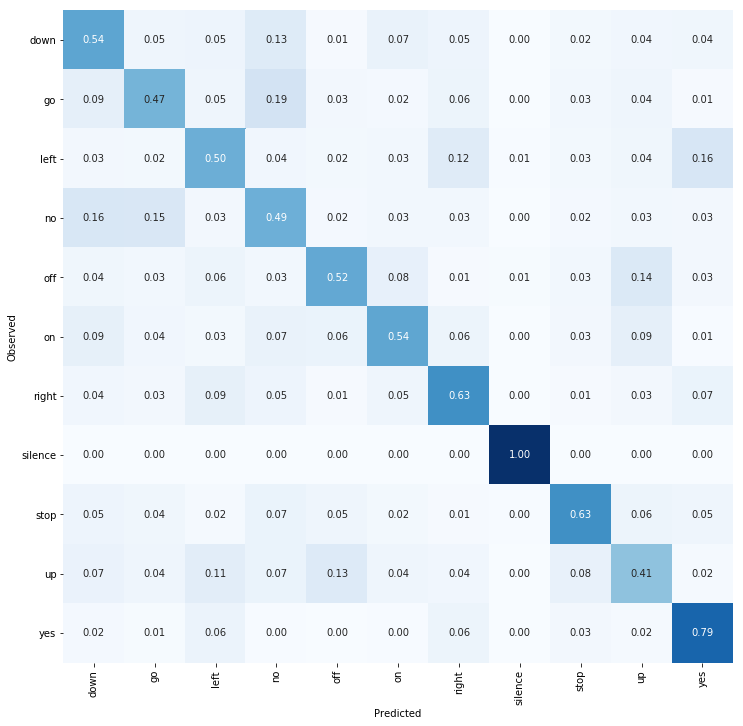

In [7]:
y_pred_perceptron = model.predict_classes(x=X_test)
helper.plot_confusion_matrix(y_test, y_pred_perceptron);

This confusion matrix tells us a little more about how the model performed. It confuses similar sounding words like "no" and "go" and "left" and "yes". This is to be expected, but notice how it also confuses "left" with "right" ~11% of the time. These words are opposite in meaning and sound very different! This is an example of words that we'll want to make sure we don't confuse. Hopefully, the more sophisticated models will have an easier time distinguishing these words apart.

# Simple Feedforward Neural Network

Now that we have a baseline performance of a single layer perceptron, let's try adding a few hidden layers and see how that impacts the performance. We'll use the same process with the early stopping monitor and the default Adam optimizer.

In [8]:
model2 = Sequential()
model2.add(InputLayer(input_shape=(X_train[0].shape)))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(11, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.fit(X_train, y_train_hot, batch_size=128, epochs=30, verbose=1,
          validation_data=(X_val, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 34069 samples, validate on 4153 samples
Epoch 1/30
34069/34069 [==============================] - 1s 40us/step - loss: 1.1837 - acc: 0.5924 - val_loss: 0.7723 - val_acc: 0.7419
Epoch 2/30
34069/34069 [==============================] - 1s 30us/step - loss: 0.6548 - acc: 0.7754 - val_loss: 0.6315 - val_acc: 0.7871
Epoch 3/30
34069/34069 [==============================] - 1s 27us/step - loss: 0.5160 - acc: 0.8233 - val_loss: 0.5873 - val_acc: 0.8057
Epoch 4/30
34069/34069 [==============================] - 1s 27us/step - loss: 0.4407 - acc: 0.8487 - val_loss: 0.5552 - val_acc: 0.8177
Epoch 5/30
34069/34069 [==============================] - 1s 27us/step - loss: 0.3868 - acc: 0.8661 - val_loss: 0.5548 - val_acc: 0.8225
Epoch 6/30
34069/34069 [==============================] - 1s 27us/step - loss: 0.3421 - acc: 0.8790 - val_loss: 0.5488 - val_acc: 0.8249
Epoch 7/30
34069/34069 [==============================] - 1s 26us/step - loss: 0.3105 - acc: 0.8920 - val_loss: 0.5259 - val_acc:

In [9]:
score = model2.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model2.metrics_names, score):
    print(name, value)

4524/4524 [==============================] - 0s 29us/step
loss 0.6300093086006986
acc 0.8229442970295273


This time our accuracy improved to ~81%. Not too bad!

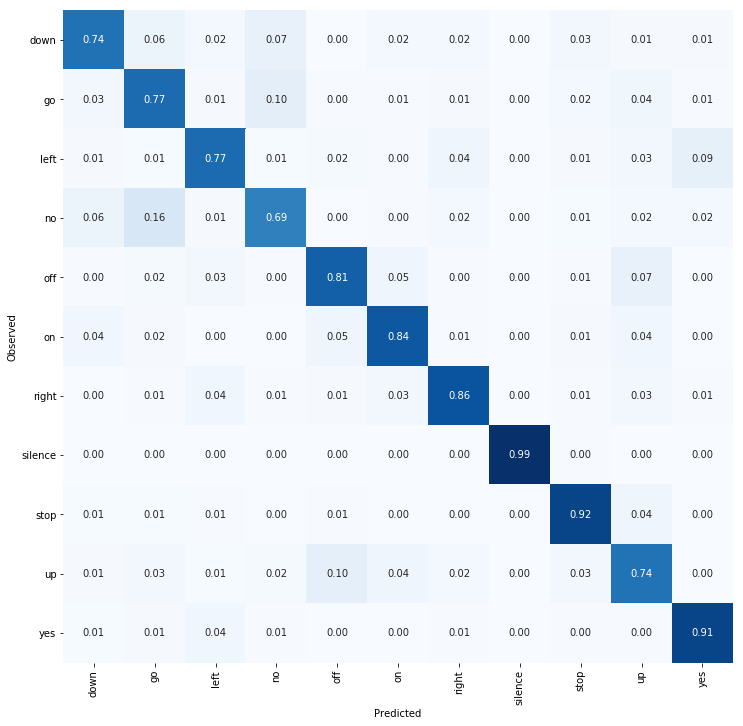

In [10]:
y_pred_ff = model2.predict_classes(x=X_test)
helper.plot_confusion_matrix(y_test, y_pred_ff);

This network shows a much better confusion matrix. It still tends to confuse similar sounding words, but notice that the confusion for "left" and "right" has already dropped significantly. 

We've shown that even a simple feedforward neural network can classify speech fairly well without too much effort. Looking forward, every additional percent in accuracy increase will become more difficult. We may need much more sophisticated models and data processing to get accuracy near 90%.

# Dealing with Unknown Words

So far, we've left the non-command words out of the analysis. The end goal is to have a model that will classify words it hasn't heard before as unknown. One way of doing this is to implement a threshold on the probabilities given by the softmax output layer - in other words, if the model is not confident enough in any particular word for a given input, it will classify it as unknown.

Let's run these trained models on the entire dataset to see what kind of probabilities it outputs for correctly classified words, incorrectly classified command words, and words that the model has not seen before. We will only be looking at the maximum confidence for each input sample.

In [11]:
X_train_total, y_train_total = helper.get_fold_data('train')
X_val_total, y_val_total = helper.get_fold_data('validation')
X_test_total, y_test_total = helper.get_fold_data('test')


X_total = {'train': X_train_total,
           'val': X_val_total,
           'test': X_test_total}

y_obs_total = {'train': y_train_total,
               'val': y_val_total,
               'test': y_test_total}

y_pred_proba_total = {'train': model.predict(X_total['train']),
                      'val': model.predict(X_total['val']),
                      'test': model.predict(X_total['test'])}

y_pred_classes_total = {'train': model.predict_classes(X_total['train']),
                        'val': model.predict_classes(X_total['val']),
                        'test': model.predict_classes(X_total['test'])}

y_pred_proba_total_ff = {'train': model2.predict(X_total['train']),
                         'val': model2.predict(X_total['val']),
                         'test': model2.predict(X_total['test'])}

y_pred_classes_total_ff = {'train': model2.predict_classes(X_total['train']),
                           'val': model2.predict_classes(X_total['val']),
                           'test': model2.predict_classes(X_total['test'])}

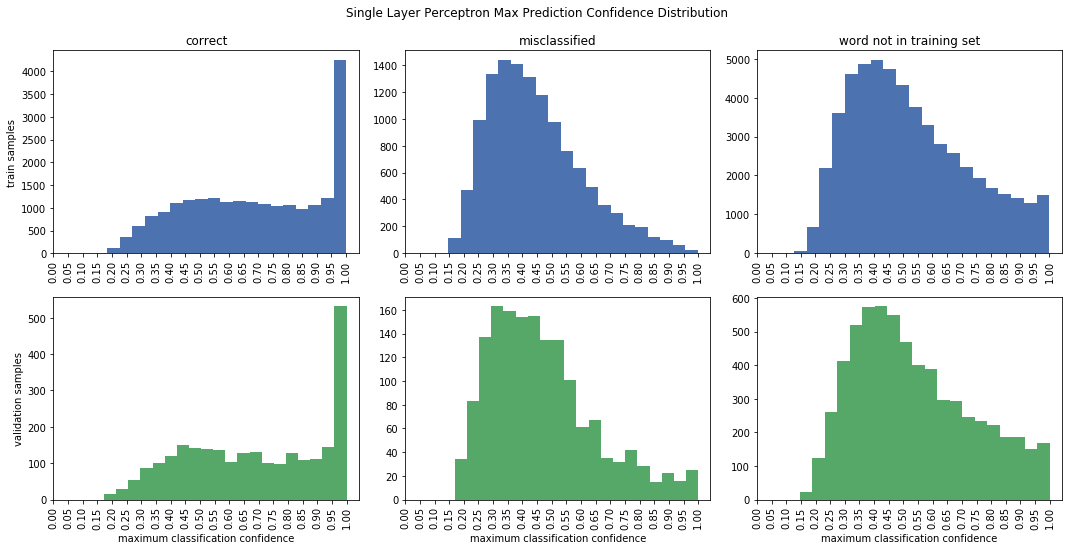

In [12]:
helper.plot_hist_grid(y_obs_total, y_pred_proba_total, y_pred_classes_total,
                      title='Single Layer Perceptron Max Prediction Confidence Distribution');

For correctly classified words, the single layer perceptron can range from being moderately confident to very confident in its prediction. The model tends to be unconfident on the misclassified words that it knows, so implementing a threshold would be pretty successful for classifying these as unknown. The prediction confidences follow a similar distribution for the words not in the command words training set, but the model appears to be very confident in many of these words. This could be due to the words sounding familiar to ones it does know (e.g. "nine" and "no").

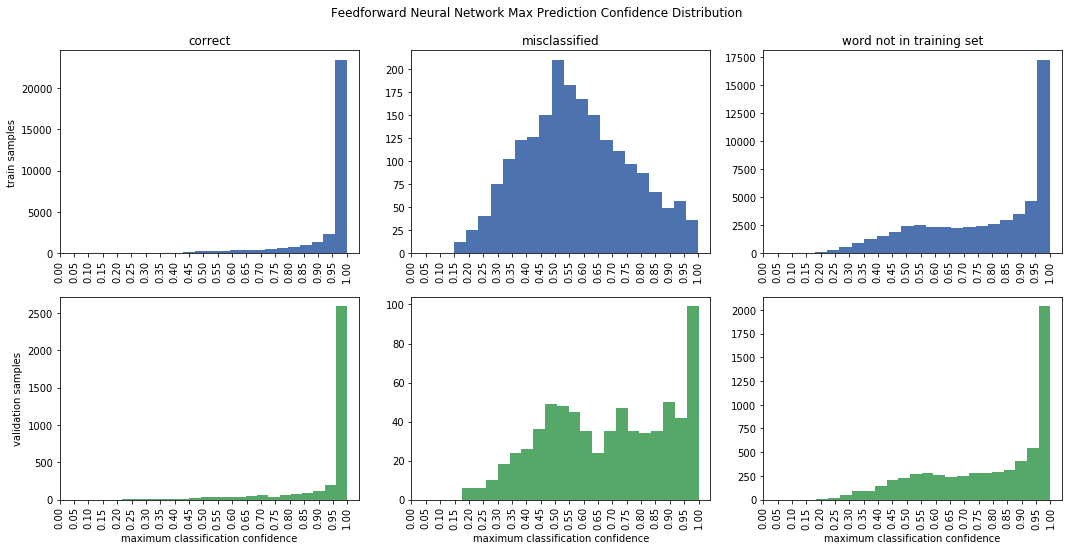

In [13]:
helper.plot_hist_grid(y_obs_total, y_pred_proba_total_ff, y_pred_classes_total_ff,
                      title='Feedforward Neural Network Max Prediction Confidence Distribution');

These results are somewhat surprising. For words it correctly classifies, the feedforward neural network appears to be very confident. However, the model appears to be confident in its predictions as well for both words it classifies incorrectly and for unknown words. This means that implementing a simple threshold to classify as "unknown" would still falsely classify many unknown words. For the future final models, we will probably need to implement a more complex method of determining unknowns, maybe by looking at the entire distribution of probabilities and not just the maximum confidence.